# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from geexhp import datavis as dvis
import matplotlib.pyplot as plt
dvis.configure_matplotlib()

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## Functions

In [3]:
# Parsing function.
def parse_example(example_proto, input, output):
    def _dense_features_process(parsed_features):
        parsed_features = tf.io.parse_single_example(example_proto, parsed_features)  

        dense_features_input = {
            key: tf.sparse.to_dense(value, default_value=0.0)
            if isinstance(value, tf.SparseTensor) else value
            for key, value in parsed_features.items()
        }
        
        return dense_features_input
    
    parsed_input = _dense_features_process(input)
    parsed_output = _dense_features_process(output)

    return parsed_input, parsed_output

In [4]:
def read_tfrecord(file, batch_size = 500):
    # Define feature description for parsing.
    #   Comment every feature that will not be used.
    input = {
        'NOISY_ALBEDO_B-NIR' : tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV' : tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis' : tf.io.VarLenFeature(tf.float32),

        # 'NOISY_ALBEDO_SS-NIR' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-UV' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-Vis' : tf.io.VarLenFeature(tf.float32),

        # 'NOISY_ALBEDO_B-NIR_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_B-UV_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_B-Vis_norm' : tf.io.VarLenFeature(tf.float32),
        
        # 'NOISY_ALBEDO_SS-NIR_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-UV_norm' : tf.io.VarLenFeature(tf.float32),
        # 'NOISY_ALBEDO_SS-Vis_norm' : tf.io.VarLenFeature(tf.float32),
    }

    output = {
        "OBJECT-RADIUS-REL-EARTH" : tf.io.FixedLenFeature([], tf.float32),
        "LOG-OBJECT-GRAVITY" : tf.io.FixedLenFeature([], tf.float32),
        "LOG-ATMOSPHERE-TEMPERATURE" : tf.io.FixedLenFeature([], tf.float32),
        "BAR-ATMOSPHERE-PRESSURE" : tf.io.FixedLenFeature([], tf.float32),

        # 'OBJECT-DIAMETER' : tf.io.FixedLenFeature([], tf.float32),
        # 'OBJECT-GRAVITY' : tf.io.FixedLenFeature([], tf.float32),
        # 'ATMOSPHERE-TEMPERATURE' : tf.io.FixedLenFeature([], tf.float32),
        # 'ATMOSPHERE-PRESSURE' : tf.io.FixedLenFeature([], tf.float32),
        
        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'log_C2H6' : tf.io.FixedLenFeature([], tf.float32),
        'log_CH4' : tf.io.FixedLenFeature([], tf.float32),
        'log_CO' : tf.io.FixedLenFeature([], tf.float32),
        'log_CO2' : tf.io.FixedLenFeature([], tf.float32),
        'log_H2O' : tf.io.FixedLenFeature([], tf.float32),
        'log_N2' : tf.io.FixedLenFeature([], tf.float32),
        'log_N2O' : tf.io.FixedLenFeature([], tf.float32),
        'log_O2' : tf.io.FixedLenFeature([], tf.float32),
        'log_O3' : tf.io.FixedLenFeature([], tf.float32)
    }

    # Read TFRecord.
    dataset = tf.data.TFRecordDataset(file)

    parsed_dataset = dataset.map(lambda x: parse_example(x, input, output), num_parallel_calls=tf.data.AUTOTUNE)

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    parsed_dataset = tf.data.Dataset.range(1).interleave(lambda _: parsed_dataset, num_parallel_calls=tf.data.AUTOTUNE)

    return parsed_dataset

# Run

In [5]:
train_ds = read_tfrecord("../data/train.tfrecord")
val_ds = read_tfrecord("../data/val.tfrecord")
test_ds = read_tfrecord("../data/test.tfrecord")

In [6]:
def build_model():
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "LOG-OBJECT-GRAVITY",
        "LOG-ATMOSPHERE-TEMPERATURE",
        "BAR-ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]
    
    input_uv = tf.keras.layers.Input(shape = (8,), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape = (94,), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape = (49,), name='NOISY_ALBEDO_B-NIR')

    x = tf.keras.layers.Concatenate()([input_uv, input_vis, input_nir])

    # Add a channel dimension to make it compatible with Conv1D
    x = tf.keras.layers.Reshape((151, 1))(x)

    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(
            units=1,
            activation='linear',
            kernel_regularizer=tf.keras.regularizers.l1(1e-5),
            name=output_name
        )(x)
        outputs[output_name] = output

    losses = {output_name: 'mae' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    learning_rate = 1e-3
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-5

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="test_1")
    model.compile(optimizer=opt, loss=losses)

    return model

In [ ]:
# This is becaouse:
# UserWarning: Your input ran out of data; interrupting training. 
# Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. 
# You may need to use the `.repeat()` function when building your dataset.
train_dataset = train_ds.repeat()

with strategy.scope():
  model = build_model()

  epochs = 10
  hist = model.fit(train_dataset, epochs=epochs, 
                  validation_data=val_ds)

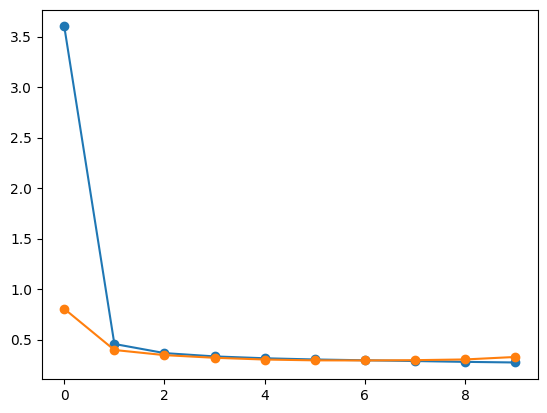

In [32]:
plt.plot(range(epochs), hist.history["loss"], marker="o", label="train loss")
plt.plot(range(epochs), hist.history["val_loss"], marker="o", label="validation loss")
plt.legend();